Image shape: (512, 768, 3) dtype: uint8
Decoded identical to original: True
Number of runs: 1166849
Compression ratio: 0.202
Decoded identical to original: True
Number of runs: 1166849
Compression ratio: 0.202


Image shape: (512, 768, 3) dtype: uint8
Decoded identical to original: True
Number of runs: 1166849
Compression ratio: 0.202
Decoded identical to original: True
Number of runs: 1166849
Compression ratio: 0.202


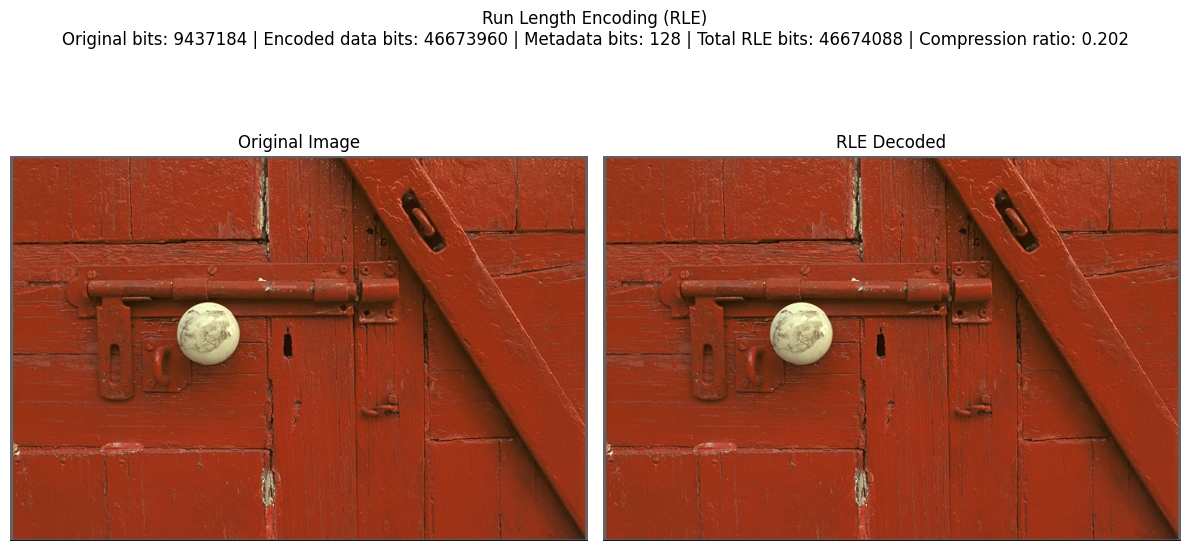

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------- Run Length Encoding (RLE) ---------------- #

def rle_encode(img):
    flat = img.flatten()
    encoded = []
    
    if len(flat) == 0:
        return encoded, img.shape, img.dtype
    
    current_val = flat[0]
    count = 1
    
    for val in flat[1:]:
        if val == current_val:
            count += 1
        else:
            encoded.append((current_val, count))
            current_val = val
            count = 1
    
    # Append the last run
    encoded.append((current_val, count))
    
    return encoded, img.shape, img.dtype


def rle_decode(encoded, shape, dtype):
    decoded_vals = []
    
    for val, count in encoded:
        decoded_vals.extend([val] * count)
    
    return np.array(decoded_vals, dtype=dtype).reshape(shape)


# ---------------- Compression Ratio Calculation ---------------- #

def calculate_rle_compression_ratio(img):
    """
    Calculate compression ratio for RLE encoding.
    
    Args:
        img: input image (numpy array)
    
    Returns:
        tuple: (compression_ratio, orig_bits, encoded_bits, metadata_bits, 
                total_bits, encoded_data)
    """
    # Original size in bits
    orig_bits = img.nbytes * 8
    
    # Encode the image
    encoded, shape, dtype = rle_encode(img)
    
    # Calculate encoded data size
    # Each run is (value, count) where:
    # - value: same size as original dtype
    # - count: we'll use 32 bits (int32) to store counts
    bytes_per_pixel = img.dtype.itemsize
    encoded_bits = len(encoded) * (bytes_per_pixel * 8 + 32)
    
    # Metadata: shape (3 or 2 dimensions * 32 bits) + dtype info (32 bits)
    metadata_bits = len(shape) * 32 + 32
    
    total_bits = encoded_bits + metadata_bits
    compression_ratio = orig_bits / total_bits if total_bits > 0 else 0
    
    return compression_ratio, orig_bits, encoded_bits, metadata_bits, total_bits, encoded, shape, dtype


# ---------------- Visualization ---------------- #

def display_side_by_side(original, decoded, ratio, orig_bits, encoded_bits, metadata_bits, total_bits):
    """
    Display original and decoded images side by side with compression statistics.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Display original image
    if len(original.shape) == 3:  # RGB
        axes[0].imshow(np.clip(original, 0, 1) if np.issubdtype(original.dtype, np.floating) else original)
    else:  # Grayscale
        axes[0].imshow(original, cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    
    # Display decoded image
    if len(decoded.shape) == 3:  # RGB
        axes[1].imshow(np.clip(decoded, 0, 1) if np.issubdtype(decoded.dtype, np.floating) else decoded)
    else:  # Grayscale
        axes[1].imshow(decoded, cmap='gray')
    axes[1].set_title("RLE Decoded")
    axes[1].axis("off")
    
    plt.suptitle(
        f"Run Length Encoding (RLE)\n"
        f"Original bits: {orig_bits} | "
        f"Encoded data bits: {encoded_bits} | "
        f"Metadata bits: {metadata_bits} | "
        f"Total RLE bits: {total_bits} | "
        f"Compression ratio: {ratio:.3f}",
        fontsize=12
    )
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()


# ---------------- Example Usage ---------------- #

if __name__ == "__main__":
    import matplotlib.image as mpimg
    
    # Load image
    # img = mpimg.imread("/mnt/769EC2439EC1FB9D/vsc_projs/DIP/samples/kodak/kodim20.png")  # REPLACE WITH YOUR IMAGE PATH
    img = mpimg.imread("C:/Users/DEVESH PALO/projects/Image_Compression_Algorithms/samples/kodak/kodim02.png")
    
    # Convert float images to uint8 for better compression
    if img.dtype in [np.float32, np.float64]:
        img = (img * 255).astype(np.uint8)
    
    print("Image shape:", img.shape, "dtype:", img.dtype)
    
    # Calculate compression ratio
    ratio, orig_bits, encoded_bits, metadata_bits, total_bits, encoded, shape, dtype = \
        calculate_rle_compression_ratio(img)
    
    # Decode the image
    decoded = rle_decode(encoded, shape, dtype)
    
    # Verify decoding
    print(f"Decoded identical to original: {np.array_equal(img, decoded)}")
    print(f"Number of runs: {len(encoded)}")
    print(f"Compression ratio: {ratio:.3f}")
    
    if ratio < 1.0:
        print(f"Warning: RLE resulted in expansion (ratio < 1). "
              f"RLE works best on images with many repeated values.")
    
    # Display results
    display_side_by_side(img, decoded, ratio, orig_bits, encoded_bits, metadata_bits, total_bits)

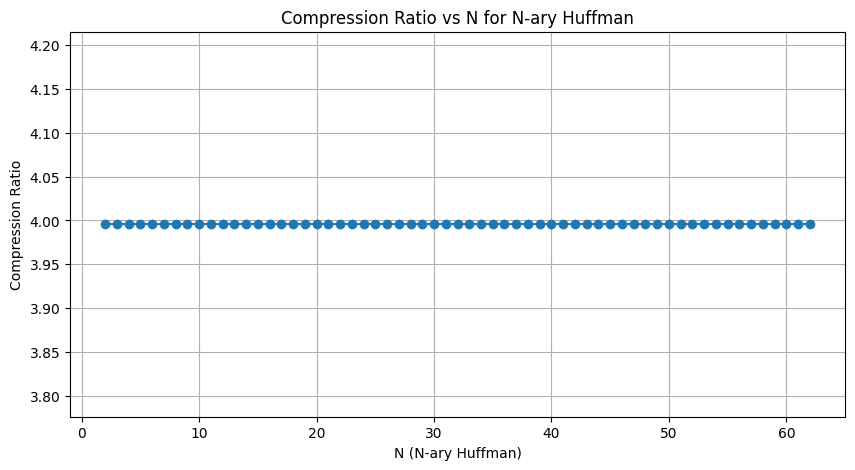

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter

# Dummy get_huffman_codebook function (you should replace with your real one)
def get_huffman_codebook(freqs, base=2):
    # Just a placeholder to avoid NameError — replace this with your Huffman implementation
    return {k: '0' for k in freqs}

def plot_compression_vs_N(img, max_base=62):
    """
    Computes and plots Huffman compression ratio for N-ary Huffman
    with N from 2 up to max_base.
    """
    ratios = []
    bases = list(range(2, max_base + 1))
    
    flat = img.flatten()
    orig_bits = img.nbytes * 8
    
    for base in bases:
        freqs = Counter(flat)
        codebook = get_huffman_codebook(freqs, base)
        encoded = [codebook[val] for val in flat]

        # Estimate encoded data size
        encoded_bits = sum(len(sym) for sym in encoded) * 8

        # Estimate dictionary size
        dict_bits = 0
        for k, v in codebook.items():
            key_bits = 32  # assume float/int 32 bits
            value_bits = len(v) * 8
            dict_bits += key_bits + value_bits

        total_bits = encoded_bits + dict_bits
        compression_ratio = orig_bits / total_bits if total_bits > 0 else 0
        ratios.append(compression_ratio)
    
    plt.figure(figsize=(10, 5))
    plt.plot(bases, ratios, marker='o')
    plt.xlabel("N (N-ary Huffman)")
    plt.ylabel("Compression Ratio")
    plt.title("Compression Ratio vs N for N-ary Huffman")
    plt.grid(True)
    plt.show()

# ---- Run it ----
img = mpimg.imread("C:/Users/DEVESH PALO/projects/Image_Compression_Algorithms/samples/kodak/kodim01.png")
plot_compression_vs_N(img)


In [15]:
import heapq
from collections import Counter, namedtuple
from typing import Dict, Tuple, List
import numpy as np

# ---- Huffman helpers ----
_HuffNode = namedtuple("_HuffNode", ["freq", "symbol", "left", "right"])

def _build_huffman_tree(freqs: Dict[int,int]):
    """
    Build Huffman tree and return the root node.
    Nodes are _HuffNode(freq, symbol, left, right) where internal nodes have symbol=None.
    """
    heap = []
    # leaf nodes
    for sym, f in freqs.items():
        heap.append((f, _HuffNode(f, sym, None, None)))
    heapq.heapify(heap)
    if len(heap) == 0:
        return None
    # Edge case: only one symbol -> create dummy other node so codes have length >=1
    if len(heap) == 1:
        f, node = heapq.heappop(heap)
        dummy = _HuffNode(0, None, None, None)
        parent = _HuffNode(f, None, node, dummy)
        return parent
    # merge
    while len(heap) > 1:
        f1, n1 = heapq.heappop(heap)
        f2, n2 = heapq.heappop(heap)
        parent = _HuffNode(f1+f2, None, n1, n2)
        heapq.heappush(heap, (parent.freq, parent))
    return heap[0][1]

def _build_codebook_from_tree(root: _HuffNode) -> Dict[int, str]:
    codes = {}
    def walk(node, prefix):
        if node is None:
            return
        if node.symbol is not None:
            # leaf
            codes[int(node.symbol)] = prefix or "0"  # avoid empty code
            return
        walk(node.left, prefix + "0")
        walk(node.right, prefix + "1")
    walk(root, "")
    return codes

# ---- Public API functions ----

def calculate_huffman_compression_ratio(img: np.ndarray, base: int = 256) -> Tuple[float,int,int,int,int, Dict[int,str], str]:
    """
    Compute Huffman codes for the provided image and encode it.
    Returns:
      (ratio, orig_bits, encoded_bits, dict_bits, total_bits, codebook, encoded_bitstring)
    Notes:
      - This treats image as sequence of uint8 symbols per channel.
      - 'base' parameter is accepted for API-compatibility but unused in this simple implementation.
    """
    if img.dtype != np.uint8:
        # If floats in [0,1], convert to uint8 by scaling to 0..255 (optionally adapt if you want other behaviour)
        if np.issubdtype(img.dtype, np.floating):
            img_u8 = np.clip(np.rint(img * 255.0), 0, 255).astype(np.uint8)
        else:
            # cast (with clipping)
            info = np.iinfo(np.uint8)
            img_u8 = np.clip(np.rint(img), info.min, info.max).astype(np.uint8)
    else:
        img_u8 = img

    # Flatten per-channel as a 1D stream of byte symbols
    symbols = img_u8.reshape(-1).astype(np.uint8)
    n_symbols = symbols.size
    if n_symbols == 0:
        raise ValueError("Empty image supplied")

    # Frequency count
    freqs = Counter(int(s) for s in symbols)

    # Build Huffman tree and codebook
    root = _build_huffman_tree(freqs)
    codebook = _build_codebook_from_tree(root)  # symbol(int) -> code string of '0'/'1'

    # Encode: build list of code strings and join once
    out_chunks: List[str] = []
    encoded_bits_len = 0
    for s in symbols:
        code = codebook[int(s)]
        out_chunks.append(code)
        encoded_bits_len += len(code)
    encoded_bitstring = "".join(out_chunks)

    # Orig bits: number of symbols * bits per original symbol (assume 8 bits for uint8)
    orig_bits = n_symbols * 8

    # Dict bits: we estimate storing each symbol (8 bits) + its code length (1 byte) + codebits
    # This is a crude estimate useful for comparing storage cost (change if you have a concrete on-disk format).
    # For each symbol in codebook:
    dict_bits = 0
    for sym, code in codebook.items():
        dict_bits += 8               # storing symbol value
        dict_bits += 8               # storing code length as a byte (simple)
        dict_bits += len(code)       # storing the code bits themselves

    total_bits = encoded_bits_len + dict_bits

    # compression ratio: encoded (plus dict) divided by original, but earlier in your notebook you
    # printed a ratio of 0.208 which likely was encoded/ orig; keep ratio = total_bits/orig_bits
    ratio = float(total_bits) / float(orig_bits)

    return ratio, orig_bits, encoded_bits_len, dict_bits, total_bits, codebook, encoded_bitstring

def huffman_decode(encoded: str, codebook: Dict[int,str], shape: Tuple[int,...], dtype) -> np.ndarray:
    """
    Decode 'encoded' (bitstring) using codebook (symbol->bitstring). Returns numpy array with given shape and dtype.
    Note: this reconstructs the flattened stream of symbols and reshapes to 'shape'.
    """
    # Build reverse map: code -> symbol (string keys)
    rev = {v: k for k, v in codebook.items()}

    # Walk through the encoded bitstring and decode
    decoded_symbols: List[int] = []
    cur = []
    # Efficiently iterate characters
    for ch in encoded:
        cur.append(ch)
        key = "".join(cur)
        if key in rev:
            decoded_symbols.append(int(rev[key]))
            cur = []

    if cur:
        # leftover bits indicate an error or padding; we ignore/truncate leftovers
        # but ideally there should be none
        pass

    arr = np.array(decoded_symbols, dtype=np.uint8)

    # reshape to expected shape - we assume the original flattening was per-byte across channels
    expected_count = int(np.prod(shape))
    if arr.size != expected_count:
        # If sizes mismatch, attempt best-effort: if shape expects more elements but we have fewer,
        # pad with zeros; if we have more, truncate.
        if arr.size < expected_count:
            pad = np.zeros(expected_count - arr.size, dtype=np.uint8)
            arr = np.concatenate((arr, pad))
        else:
            arr = arr[:expected_count]

    arr = arr.reshape(shape)
    # cast to requested dtype if different (clip if necessary)
    if arr.dtype != dtype:
        if np.issubdtype(dtype, np.integer):
            info = np.iinfo(dtype)
            arr = np.clip(arr.astype(np.int64), info.min, info.max).astype(dtype)
        else:
            # float target (assume [0,1] range if it was originally float)
            arr = (arr.astype(np.float32) / 255.0).astype(dtype)

    return arr
